In [2]:
import os
import cv2
import json
import glob
import shutil
import time

import PBL_detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PBL_detection import *
from Roots_point_detect_tool import*
from pattern_detection_tool import*
from tqdm.notebook import tqdm as tqdm

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [3]:
start = 0
end = 500

In [4]:
step = 2

In [6]:
#First time Rebuild = True
Rebuild = False
folder_build_path = './'
# sub_folder_name_list = ['1_o_image','1_roots_mask','1_seg_image','2_seg_img_with_cej',
#                         '3_pattern_detection_result','3_draw_all_points_on_o_img',
#                         '3_draw_all_points_on_seg_img','4_result_with_label',
#                         'csv_file','Result_comparison']
sub_folder_name_list = ['1_o_image','1_roots_mask','1_seg_image','2_seg_img_with_cej',
                        '3_pattern_detection_result','3_draw_all_points_on_o_img',
                        '3_draw_all_points_on_seg_img','4_result_with_label',
                        ]
if not Rebuild and os.path.exists(folder_build_path):
    print('This folder is exist,if want to rebuild please modify "Rebuild" parameter.')
else:
    for sub_folder_name in sub_folder_name_list:
        folder_builder(folder_build_path,sub_folder_name,Rebuild)
    print('Initial the all folder.')

This folder is exist,if want to rebuild please modify "Rebuild" parameter.


# 0817 Read step 2 section

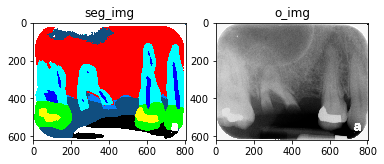

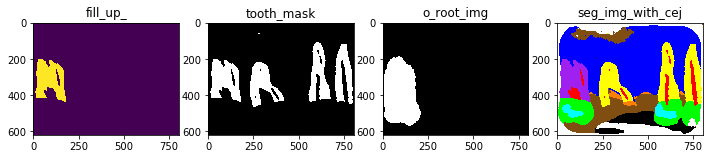

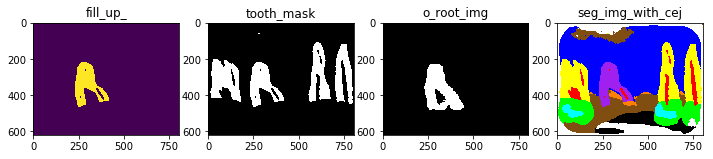

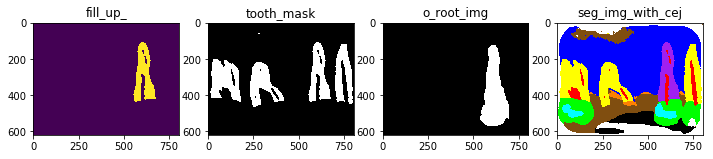

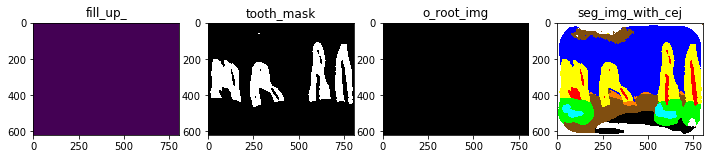

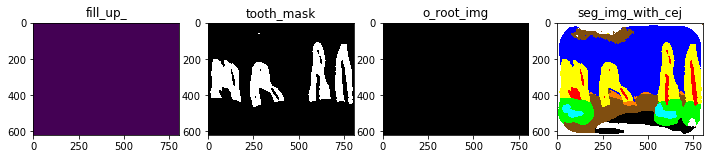

KeyboardInterrupt: 

In [7]:
#STEP 2 Using split root_dilation to be mask,shift the root to match cej,
folder_build_path = './'

seg_image_folder = os.path.join(folder_build_path,'1_seg_image')
seg_image_path_list = glob.glob(seg_image_folder+'/*.PNG')
seg_image_path_list.sort()

split_root_folder = os.path.join(folder_build_path,'1_roots_mask')
split_root_path_list = glob.glob(split_root_folder+'/*.PNG')
split_root_path_list.sort()

seg_img_with_cej_save_path = os.path.join(folder_build_path,'2_seg_img_with_cej')

have_save_path = os.path.join(folder_build_path,'2_seg_img_with_cej')
have_save_path_list = glob.glob(have_save_path+'/*.PNG')
have_save_path_list.sort() 


# if show,save = true would show,save image what this block create
show = True
save = False
save_file_type = '.PNG'
print_ = False


# seg_image_path_list = seg_image_path_list[:end]

for index, seg_image_path in tqdm(enumerate(seg_image_path_list), total = len(seg_image_path_list)):
    img_name = get_name_from_path(seg_image_path, False)
    if print_:
        print(img_name)
    #load all root image in folder('./1_roots_mask')
    roots_img_path_list = [root_name for root_name in split_root_path_list if img_name in root_name]
    
    #check image is already fill in folder ('./2_seg_img_with_cej')
    have_fill_num = [root_name for root_name in have_save_path_list if img_name in root_name]
    
    #cheeck len of both list on above are sanme,if same skip this iamge name
    #if you want debug or run,comment out followimg two line let for loop run all flow
    if len(roots_img_path_list)==len(have_fill_num):
        continue
        
    #load original image
    o_img = cv2.imread(seg_image_path.replace('1_seg_image','1_o_image'),0)    
    #load segmentation image
    seg_img = cv2.imread(seg_image_path)

    if print_:
        print(show_pixel_set(seg_img))
    
    #if you would change image pixel value, using copy() to init new memory to copy image
    seg_img_copy = seg_img.copy()
    #BGR to GRAY for numpy to search target area
    seg_img_copy_gray = cv2.cvtColor(seg_img_copy, cv2.COLOR_BGR2GRAY)
    #tooth color in grayscale is 226 
    tooth_mask = np.where(seg_img_copy_gray==226,1,0).astype('uint8')
    
    #function to know image is upper tooth or lower tooth or having both side.
    #upper or lower have different alogrithm for PBL detection, having both side image would skip
    forward, value = tooth_forward(seg_img)
    
    if print_:
        check_status(value)
    #show image
    if show:
        plt.subplot(121)
        plt.title('seg_img')
        plt.imshow(seg_img_copy)
        plt.subplot(122)
        plt.title('o_img')
        plt.imshow(o_img, cmap = 'gray')
        plt.show()
    
    #load all root image to fill segmentation and save
    for o_root_path in roots_img_path_list:
        #get name shape is ABC.PNG
        root_name = o_root_path.split('/')[-1]
        
        #read image
        o_root_img = cv2.imread(o_root_path,0)
        
        #ensure shape same as o_image
        o_root_img = cv2.resize(o_root_img,o_img.shape[:2][::-1],interpolation = cv2.INTER_NEAREST)
        
        #function to get fill mask 
        #plt.imshow(image)
        #plt.show()
        #can plt on jupyter notebooks
        fill_up_ = get_boundary_line_by_inertia(o_root_img, tooth_mask)
        
        #combine mask in segmentation
        seg_img_with_cej = combine_seg_cej(seg_img_copy,fill_up_).astype('uint8')
        
        #save in folder (./2_seg_img_with_cej)
        if save:
            cv2.imwrite(os.path.join(seg_img_with_cej_save_path,root_name), seg_img_with_cej)
            
        #plt result
        if show:
            plt.figure(figsize=(12,12))
            plt.subplot(141)
            plt.title('fill_up_')
            plt.imshow(fill_up_)
            plt.subplot(142)
            plt.title('tooth_mask')
            plt.imshow(tooth_mask, cmap = 'gray')
            plt.subplot(143)
            plt.title('o_root_img')
            plt.imshow(o_root_img, cmap = 'gray')
            plt.subplot(144)
            plt.title('seg_img_with_cej')
            plt.imshow(cv2.cvtColor(seg_img_with_cej,cv2.COLOR_BGR2RGB))
            plt.show()

In [ ]:
#initial csv file
Resave = False
csv_file_path = './PBL_result_1.csv'

if not Resave and os.path.exists(csv_file_path):
    print('This csv file is exist,if want to resave please modify "Resave" parameter.')
else:
    print('Initial the csv.')
    with open(csv_file_path, 'w', newline='\n') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image_name', 'Tooth_num', 'LPBL(%)', 'L_Stage(int)', 'RPBL(%)', 'R_Stage(int)','Dis_L','Dis_R','Dis_root','points_info','tooth_pbl_line_path'])

In [ ]:
def PBL_Detect(fill_up_img, value, imgarray, roots_point, cej_points,bone_points, line_of_inertia, molar):
    print_ = False
    roots_point = list(sorted(roots_point, key = lambda x:x[0]))
    cej_points = list(sorted(cej_points, key = lambda x:x[0]))
    bone_points = list(sorted(bone_points, key = lambda x:x[0]))
    RGB_image = cv2.cvtColor(imgarray, cv2.COLOR_GRAY2RGB)
    img_PBL_line = RGB_image.copy()
    L_side = False
    R_side = False
    
    cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
    bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
    line_of_inertia_copy = line_of_inertia.copy()
    
    if sum(cej_num_list) == 1 and sum(bone_num_list) == 1:
        L_side = True
    if len(cej_points) - sum(cej_num_list) == 1 and len(bone_points) - sum(bone_num_list)==1:
        R_side = True
    #print("L_side:",L_side,"R_side:",R_side)
    
    LPBL, RPBL = -999, -999
    Dis_L = -999
    Dis_R = -999
    Dis_root = -999
    
    points_info = tuple((sum(cej_num_list),sum(bone_num_list),len(cej_points) - sum(cej_num_list),len(bone_points) - sum(bone_num_list)))
    if print_:
        print('L_side:',L_side,'R_side:',R_side)
        print('roots_point:',roots_point)
        print('bone_points:',bone_points)
        print('cej_points:',cej_points)
#     molar = False

#     if L_side and R_side and not molar:
#         cej_center_point = [int((cej_points[0][0]+cej_points[1][0])/2),int((cej_points[0][1]+cej_points[1][1])/2)]
#         cv2.line(img_PBL_line, (bone_points[0][0], bone_points[0][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 5)
#         cv2.line(img_PBL_line, (cej_points[0][0], cej_points[0][1]), (cej_points[1][0], cej_points[1][1]), (255, 0, 0), 5)
#         cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_center_point[0], cej_center_point[1]), (0, 0, 255), 5)

#         cv2.line(img_PBL_line, (cej_points[0][0],cej_points[0][1]), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         cv2.line(img_PBL_line, (cej_points[1][0],cej_points[1][1]), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[0],cej_points[0],cej_points[1])), (bone_points[0][0], bone_points[0][1]), (0, 255, 0), 2)
#         #cv2.line(img_PBL_line, (crosspoint_point2line(bone_points[1],cej_points[0],cej_points[1])), (bone_points[1][0], bone_points[1][1]), (0, 255, 0), 2)

#         cv2.circle(img_PBL_line, (roots_point[0][0], roots_point[0][1]), 3 , (0, 0, 255), 10)
#         cv2.circle(img_PBL_line, (bone_points[0][0], bone_points[0][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (bone_points[1][0], bone_points[1][1]), 3 , (0, 255, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[0][0], cej_points[0][1]), 3 , (255, 0, 0), 10)
#         cv2.circle(img_PBL_line, (cej_points[1][0], cej_points[1][1]), 3 , (255, 0, 0), 10)
#         LPBL = (distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)
#         RPBL = (distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))*0.05-2)/(distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))*0.05-2)

#         Dis_L = distance_point2line(np.array(bone_points[0]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_R = distance_point2line(np.array(bone_points[1]),np.array(cej_points[0]),np.array(cej_points[1]))
#         Dis_root = distance_2_points(np.array(roots_point[0]),np.array(cej_center_point))
#         if LPBL < 0:
#             LPBL = 0
#         if RPBL < 0:
#             RPBL = 0
#         return True, round(LPBL*100,3), PBL_stage(LPBL), round(RPBL*100,3), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root, img_PBL_line,points_info
    if L_side:
        if molar:
            root_x, root_y, line_of_inertia = get_molar_root(fill_up_img, value, line_of_inertia, 'L')
            roots_point = list(sorted(zip(root_x, root_y), key = lambda x:x[0]))
            cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
            bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
            
        if sum(cej_num_list) == 1 and sum(bone_num_list) == 1:
            cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])
            bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(True)],line_of_inertia[0],line_of_inertia[1])

            cv2.circle(img_PBL_line, (roots_point[0]), 5, (0, 0, 255), -1)
            cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0], cej_points[cej_num_list.index(True)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
            cv2.line(img_PBL_line, (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(True)][0],cej_points[cej_num_list.index(True)][1]), (bone_points[bone_num_list.index(True)][0], bone_points[bone_num_list.index(True)][1]), (0, 255, 0), 2)

            LPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
            Dis_L = distance_2_points(np.array(cej_points[cej_num_list.index(True)]),np.array(bone_points[bone_num_list.index(True)]))
            Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
            if LPBL < 0:
                LPBL = 0
        else:
            pass

    if R_side:
        if molar:
            root_x, root_y, line_of_inertia = get_molar_root(fill_up_img, value, line_of_inertia_copy, 'R')
            roots_point = list(sorted(zip(root_x, root_y), key = lambda x:x[0]))
            cej_num_list = [point_in_left_side_of_line(cej,line_of_inertia[0],line_of_inertia[1]) for cej in cej_points]
            bone_num_list = [point_in_left_side_of_line(bone,line_of_inertia[0],line_of_inertia[1]) for bone in bone_points]
        if ((len(cej_num_list) - sum(cej_num_list)) == 1) and ((len(bone_points) - sum(bone_num_list))==1):      
            cej_cross_point_with_inertia = crosspoint_point2line(cej_points[cej_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])
            bone_cross_point_with_inertia = crosspoint_point2line(bone_points[bone_num_list.index(False)],line_of_inertia[0],line_of_inertia[1])

            cv2.circle(img_PBL_line, (roots_point[0]), 5, (0, 0, 255), -1)
            cv2.line(img_PBL_line, (roots_point[0][0], roots_point[0][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (0, 0, 255), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0], cej_points[cej_num_list.index(False)][1]), (cej_cross_point_with_inertia[0], cej_cross_point_with_inertia[1]), (255, 0, 0), 5)
            cv2.line(img_PBL_line, (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (bone_cross_point_with_inertia[0], bone_cross_point_with_inertia[1]), (0, 255, 0), 5)
            cv2.line(img_PBL_line, (cej_points[cej_num_list.index(False)][0],cej_points[cej_num_list.index(False)][1]), (bone_points[bone_num_list.index(False)][0], bone_points[bone_num_list.index(False)][1]), (0, 255, 0), 2)

            RPBL = (distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))*0.05-2)/(distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))*0.05-2)
            Dis_R = distance_2_points(np.array(cej_points[cej_num_list.index(False)]),np.array(bone_points[bone_num_list.index(False)]))
            Dis_root = distance_2_points(np.array(cej_cross_point_with_inertia),np.array(roots_point[0]))
            if RPBL < 0:
                RPBL = 0
        else:
            pass
            
    if L_side or R_side:
        return True, max(round(LPBL*100,3), -999), PBL_stage(LPBL), max(round(RPBL*100,3), -999), PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info
    else:
        LPBL, RPBL = -999, -999
        Dis_L = -999
        Dis_R = -999
        Dis_root = -999
        img_PBL_line_copy = img_PBL_line.copy()
        fill_up_img = np.expand_dims(fill_up_img, axis=2)
        fill_up_img = np.where(fill_up_img>0,1,0).astype('uint8')
        cv2.line(img_PBL_line_copy, (line_of_inertia[0][0], line_of_inertia[0][1]), (line_of_inertia[1][0], line_of_inertia[1][1]), (0, 0, 255), 5)
        img_PBL_line_copy*=fill_up_img
        img_PBL_line*=abs(1-fill_up_img)
        img_PBL_line += img_PBL_line_copy
        return False,LPBL, PBL_stage(LPBL), RPBL, PBL_stage(RPBL),Dis_L,Dis_R,Dis_root,img_PBL_line,points_info

In [ ]:
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

def point_in_box(point_boxs_list,check_point):
    point_pair_list = [[point_boxs_list[i-1],point_boxs_list[i]] for i in range(len(point_boxs_list))]
    box_area = PolygonArea(point_boxs_list)
    count_area = 0
    for edge in point_pair_list:
        edge.append(check_point)
        count_area = PolygonArea(edge)+count_area
    if count_area - box_area < 1:
        return True
    else:
        return False
    
def get_molar_bool(json_file_path, check_point):
    with open(json_file_path, 'r') as file:
        json_file = json.load(file)
    for tooth in json_file['shapes']:
        check_in_box = point_in_box(tooth['points'],check_point)
        if check_in_box:
            tooth_num = int(tooth['label'].split('_')[0])
            if (tooth_num >= 1 and tooth_num <=3) or (tooth_num >= 14 and tooth_num <=19) or (tooth_num >= 30 and tooth_num <=32):
                return True
            else:
                return False
    return False

In [ ]:
def get_molar_root(fill_up_img, value, line_of_inertia, type_):
    y_list,x_list = np.nonzero(fill_up_img)
    
    L_fill_up = fill_up_img.copy()
    if type_ == 'L':
        point_in_left = [point_in_left_side_of_line([x_,y_],line_of_inertia[0],line_of_inertia[1]) for (x_, y_) in zip(x_list,y_list)]
        for bool_, x_, y_ in zip(point_in_left, x_list, y_list):
            if (not bool_):
                L_fill_up[y_,x_] = 0
        root_x, root_y,line_of_inertia = root_point_detect(L_fill_up,value)
#         plt.imshow(L_fill_up)
#         plt.show()
        return root_x, root_y,line_of_inertia

    if type_ == 'R':
        R_fill_up = fill_up_img.copy()
        point_in_left = [point_in_left_side_of_line([x_,y_],line_of_inertia[0],line_of_inertia[1]) for (x_, y_) in zip(x_list,y_list)]
        for bool_, x_, y_ in zip(point_in_left, x_list, y_list):
            if bool_:
                R_fill_up[y_,x_] = 0          
        root_x, root_y,line_of_inertia = root_point_detect(R_fill_up,value)
#         plt.imshow(R_fill_up)
#         plt.show()
        return root_x, root_y,line_of_inertia

In [ ]:
folder_build_path = './'

#Using filled up tooth & segmentation with cej levle to Pattern detection key point
o_image_folder = os.path.join(folder_build_path,'1_o_image')
o_image_path_list = glob.glob(o_image_folder+'/*.PNG')
o_image_path_list.sort()

seg_image_folder = os.path.join(folder_build_path,'1_seg_image')
seg_image_path_list = glob.glob(seg_image_folder+'/*.PNG')
seg_image_path_list.sort()

split_root_folder = os.path.join(folder_build_path,'1_roots_mask')
split_root_path_list = glob.glob(split_root_folder+'/*.PNG')
split_root_path_list.sort()

seg_img_with_cej_folder = os.path.join(folder_build_path,'2_seg_img_with_cej')
seg_img_with_cej_path_list = glob.glob(seg_img_with_cej_folder+'/*.PNG')
seg_img_with_cej_path_list.sort()

json_folder = os.path.join('/root/notebooks/jeff/json_file/*.json')
json_list = glob.glob(json_folder)
json_list.sort()

loss_root_count = 0

pattern_detection_result_save_path = './3_pattern_detection_result'
draw_all_points_on_o_img_save_path = './3_draw_all_points_on_o_img'
draw_all_points_on_seg_img_save_path = './3_draw_all_points_on_seg_img'

# pattern_detection_result_save_path = os.path.join(folder_build_path,'3_pattern_detection_result')
# draw_all_points_on_o_img_save_path = os.path.join(folder_build_path,'3_draw_all_points_on_o_img')
# draw_all_points_on_seg_img_save_path = os.path.join(folder_build_path,'3_draw_all_points_on_seg_img')

# if show,save = true would show,save image what this block create
PBL_status = False
show = False
save = True
CSV = True
save_file_type = '.PNG'
print_ = False
molar = True
count = 0
tooth_count = 0
seg_image_path_list = sorted(seg_image_path_list)
seg_image_path_list = seg_image_path_list[start:end]

for seg_image_path in tqdm(seg_image_path_list,total = len(seg_image_path_list)):
    img_name = get_name_from_path(seg_image_path,False)
#     if 'NN_180821_160705_16ED77' not in img_name:
#         continue
        
    if True:
        if False:
            print(img_name) 
        roots_img_path_list = [root_name for root_name in split_root_path_list if img_name in root_name]
        o_img = cv2.imread(seg_image_path.replace('1_seg_image','1_o_image'),0)
        seg_img = cv2.imread(seg_image_path)
        forward, value = tooth_forward(seg_img)
        #print(value)
        #check_forward_status(value)
    #     if not forward:
#         plt.subplot(121)
#         plt.title('seg_img')
#         plt.imshow(seg_img)
#         plt.subplot(122)
#         plt.title('o_img')
#         plt.imshow(o_img, cmap = 'gray')
#         plt.show()
#         print(check_forward_status(value))

        if forward:
            target_json_file = [file_path for file_path in json_list if img_name in file_path]
            if len(target_json_file)==0:
                loss_root_count+=1
                continue
            for fill_up_path in roots_img_path_list:
                count+=1
                o_img_copy = o_img.copy()
                
                fill_up_name = get_name_from_path(fill_up_path,True)
                fill_up_img = cv2.imread(fill_up_path,0)
                fill_up_img = cv2.resize(fill_up_img,o_img_copy.shape[:2][::-1],interpolation = cv2.INTER_NEAREST)
                
                seg_img_with_cej_img = cv2.imread(fill_up_path.replace('1_roots_mask','2_seg_img_with_cej'))
                check_point = (np.mean(np.nonzero(fill_up_img)[1]),np.mean(np.nonzero(fill_up_img)[0]))
                molar = get_molar_bool(target_json_file[0], check_point)
                (cej_x,cej_y),(bone_x,bone_y) = find_cej_bone_keypoint(seg_img_with_cej_img)
                root_x, root_y,line_of_inertia = root_point_detect(fill_up_img,value)
                ####################################
                ####################################
                (cej_x,cej_y),(bone_x,bone_y) = keypoint_filter(zip(cej_x,cej_y),zip(bone_x,bone_y),line_of_inertia,value,fill_up_img)

                if (len(cej_x) == 1) and (len(cej_y) == 1):
                    (cej_x, cej_y) = cej_recover(cej_x, cej_y, line_of_inertia, fill_up_img)
                if (len(bone_x) < 2) and (len(bone_y) < 2):
                    (bone_x, bone_y) = bone_recover(bone_x, bone_y, fill_up_img, line_of_inertia, seg_img_with_cej_img, value, molar)
                ####################################
                #################################### 
                if root_x[0] != None:
                    if print_:
                        print('Find {} root point in this image'.format(len(root_x)))
                        print(root_x,root_y)
                        print('Find {} cej point in this image'.format(len(cej_x)))
                        print(cej_x,cej_y)
                        print('Find {} bone point in this image'.format(len(bone_x)))
                        print(bone_x,bone_y)
                    #molar = True
                    PBL_status, LPBL, L_Stage, RPBL, R_Stage,Dis_L,Dis_R,Dis_root,img_PBL_line,points_info = PBL_Detect(fill_up_img,value,o_img_copy,zip(root_x,root_y),zip(cej_x,cej_y),zip(bone_x,bone_y),line_of_inertia,molar)

                    if print_:
                        print('Dectation LPBL is : {}%'.format(LPBL))
                        print('Dectation RPBL is : {}%'.format(RPBL))
                    tooth_pbl_line_path = os.path.join(pattern_detection_result_save_path,fill_up_name)
                    tooth_pbl_draw_all_points_on_o_img_path = os.path.join(draw_all_points_on_o_img_save_path,fill_up_name)
                    tooth_pbl_draw_all_points_on_seg_img_path = os.path.join(draw_all_points_on_seg_img_save_path,fill_up_name)
                    ####################
                    if CSV:
                        # List of strings
                        #example:['Image_name', 'Tooth_num', 'LPBL', 'L_Stage', 'RPBL', 'R_Stage','tooth_pbl_line_path']
                        row_contents = [img_name, fill_up_name, LPBL, L_Stage , RPBL, R_Stage,Dis_L,Dis_R,Dis_root,points_info,tooth_pbl_line_path]

                        # Append a list as new line to an old csv file
                        append_list_as_row(csv_file_path, row_contents)
                    ####write points
                    o_img_copy = cv2.cvtColor(o_img_copy, cv2.COLOR_GRAY2RGB)
                    for x,y in zip(root_x,root_y):
                        cv2.circle(o_img_copy,(x, y), 4, (0, 0, 255), -1)
                        cv2.circle(seg_img_with_cej_img,(x, y), 4, (255, 255, 255), -1)
                    for x,y in zip(bone_x,bone_y):
                        cv2.circle(o_img_copy,(x, y), 4, (0, 255, 0), -1)
                        cv2.circle(seg_img_with_cej_img,(x, y), 4, (255, 255, 0), -1)
                    for x,y in zip(cej_x,cej_y):
                        cv2.circle(o_img_copy,(x, y), 4, (255, 0, 0), -1)
                        cv2.circle(seg_img_with_cej_img,(x, y), 4, (0, 255, 255), -1)
                    ##############
                    if save:
                        cv2.imwrite(tooth_pbl_line_path, img_PBL_line)
#                         cv2.imwrite(tooth_pbl_draw_all_points_on_o_img_path, o_img_copy)
#                         cv2.imwrite(tooth_pbl_draw_all_points_on_seg_img_path, seg_img_with_cej_img)
                    if show and PBL_status:
                        plt.figure(figsize=(15,15))
                        plt.subplot(141)
                        plt.title('fill_up_img')
                        plt.imshow(fill_up_img, cmap = 'gray')
                        plt.subplot(142)
                        plt.title('seg_img_with_cej_img')
                        plt.imshow(cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2RGB))
                        plt.subplot(143)
                        plt.title('o_img')
                        plt.imshow(o_img_copy)
                        plt.subplot(144)
                        plt.title('img_PBL_line')
                        plt.imshow(cv2.cvtColor(img_PBL_line,cv2.COLOR_BGR2RGB))
                        plt.show()
                    elif show:
                        plt.figure(figsize=(12,12))
                        plt.subplot(131)
                        plt.title('fill_up_img')
                        plt.imshow(fill_up_img, cmap = 'gray')
                        plt.subplot(132)
                        plt.title('seg_img_with_cej_img')
                        plt.imshow(cv2.cvtColor(seg_img_with_cej_img,cv2.COLOR_BGR2RGB))
                        plt.subplot(133)
                        plt.title('o_img')
                        plt.imshow(cv2.cvtColor(o_img_copy,cv2.COLOR_BGR2RGB))
                        plt.show()
                else:
                    print("can't find the root", fill_up_name)
print('loss_root_count',loss_root_count)

In [ ]:
def point_in_left_side_of_line(point,line_edge1,line_edge2):
    dy = line_edge2[1]-line_edge1[1]
    dx = line_edge2[0]-line_edge1[0]
    if(dx==0):
        if(line_edge2[0]>point[0]):
            return True
        else:
            return False
    if(dy==0):
        dy = 1   
    try:
        m = (dy/dx)
    except:
        print('gradient error')
    c = line_edge1[1]-m*line_edge1[0]
    if (point[1] - (m*point[0]) - c) < 0:
        return True
    else:
        return False

In [ ]:
line_of_inertia[0],line_of_inertia[1] (506, 1423) (369, -571)
cej_final_points: [(399, 480)]
cej_final_side: [False]
1
cej_num_list: [False]
cej_right_points: (399, 480)
cej_left_points: []
bone_num_list: [False]
bone_right_points: [(394, 452)]
bone_left_points: []
cej_x: [399]
cej_y: [480]
cej_x: [399] cej_y: [480]
bone_x: [394] bone_y: [452]
-------------------------------
L_side: False R_side: True

In [ ]:
point_in_left_side_of_line((0, 0),(506, 1423),(369, -571))

In [ ]:
point_in_left_side_of_line((0, 0),(4, 0),(0, 4))

In [ ]:
# def point_in_left_side_of_line(point,line_edge1,line_edge2):
#     try:
#         m = (line_edge2[1]-line_edge1[1])/(line_edge2[0]-line_edge1[0])
#     except:
#         m = (line_edge2[1]-line_edge1[1])/(1)
#     c = line_edge1[1]-m*line_edge1[0]
#     if (point[1] - c)/m >= point[0]:
#         return True
#     else:
#         return False
    

In [ ]:
line_of_inertia[0]: (253, 1318)
line_of_inertia[1]: (58, -672)
cej_points: [(75, 252)]
bone_points: [(219, 362)]

In [ ]:
img = np.ones((10,10,3),np.uint8)
purple = np.array([240, 32, 160])
red = np.array([0, 0, 255])
img = img*purple

img_gray = cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2GRAY)
print(img_gray[0][0])

In [ ]:
plt.imshow(cv2.cvtColor(img.astype('uint8'),cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
point_in_left_side_of_line((4,4),(0,4),(4,0))